In [1]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64, prange
import numba
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix
from datetime import datetime
from qutip import sigmax, sigmay, sigmaz, jmat
import time
import h5py
from labellines import labelLine, labelLines
from time import sleep

In [2]:
from constants import *

In [15]:
a_par_weight = 0 # A_par/C_zz ~ 50k

file = "reconstructed_apar_sweep_full.hdf5"
couplings_file = "couplings_quarter_full.hdf5"

keep_partial_solutions = False

max_distance = 9
target_B = np.array([0,0.9])/180*np.pi

# State reconstruction

In [4]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
            index // (max_distance**2 * site_nb) - center,
            index // (max_distance * site_nb) % max_distance - center,
            index // site_nb % max_distance - center,
            index % site_nb
        )

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return (
                            (
                                (
                                    (vec[0] + center)*max_distance + (vec[1] + center)
                                )*max_distance
                                + (vec[2] + center)
                            )*site_nb
                            + vec[3]
                       
       )

In [5]:
@jit
def exchange_columns(couplings, permutation, a, b):
    a, b = min(a, b), max(a, b)
    permutation[a], permutation[b] = permutation[b], permutation[a]
    for i in range(a):
        couplings[i, a], couplings[i, b] = couplings[i, b], couplings[i, a]
    for i in range(a+1, b):
        couplings[a, i], couplings[i, b] = couplings[i, b], couplings[a, i]
    for i in range(b+1, couplings.shape[0]): 
        couplings[a, i], couplings[b, i] = couplings[b, i], couplings[a, i]

@jit(parallel=True)
def all_error_cost(configs, coupl, a_par_data, nb_par_data, n_max, all_couplings, a_par, nb_par, a_par_weight, nb_par_weight, tolerance, nb_tolerance):
    errors = np.zeros(len(configs))
    n = coupl.shape[0]
    for k in prange(len(configs)):
        err = 0.0
        config = configs[k]
        for i in range(n_max):
            if not np.isnan(a_par_data[i]):
                err += a_par_weight * (a_par[config[i]] - a_par_data[i])**2
            if np.isnan(nb_par[config[i]]) or np.abs(nb_par[config[i]] - nb_par_data[i]) > nb_tolerance:
                err = np.inf
                break
            if not np.isnan(nb_par_data[i]):
                err += nb_par_weight * (nb_par[config[i]] - nb_par_data[i])**2
            for j in range(i+1, n_max):
                if np.isnan(all_couplings[config[i], config[j]]) or np.abs(all_couplings[config[i], config[j]] - coupl[i,j]) > tolerance:
                    err = np.inf
                    break
                if not np.isnan(coupl[i, j]):
                    err += (coupl[i, j] - all_couplings[config[i], config[j]])**2
            if err == np.inf:
                break
        errors[k] = err
    return errors

In [6]:
def check_configuration(sites, original):
    """
    Check if configurations are the same up to a translation
    """
    x_sites = np.min(sites[:,0])
    x_original = np.min(original[:,0])
    y_sites = np.min(sites[:,1])
    y_original = np.min(original[:,1])
    z_sites = np.min(sites[:,2])
    z_original = np.min(original[:,2])

    # useless allocation here we could do it in place...
    sites = sites + np.array([[x_original - x_sites, y_original - y_sites, z_original - z_sites, 0]])
    sites = np.sort(sites, axis=0)
    original = np.sort(original, axis=0)
    return np.array_equal(sites, original)

    
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

###  Load data

In [7]:
from measurement_data import data_header, renormalized_data, a_par_data, nb_par_data

### Compute

In [8]:
with (
    h5py.File(file, "r") as g,
    h5py.File(couplings_file, "r") as f
):
    all_final_sites = []
    all_errors = []
    all_B = []
    all_permutations = []
    all_keys = []
    a_par_keys = []
    for a_par_key, gg in tqdm(g.items()):
        
        if a_par_key.startswith("measured"):
            continue
        i = 0
        x_size = f.attrs["x_end"] - f.attrs["x_start"]
        y_size = f.attrs["y_end"] - f.attrs["y_start"]
        all_errors.append(np.empty(x_size * y_size))
        all_B.append(np.empty((x_size * y_size,3)))
        all_final_sites.append(np.empty((x_size * y_size, len(a_par_data)), dtype = np.uint64))
        all_permutations.append(np.empty((x_size * y_size, len(a_par_data)), dtype = np.uint64))
        all_keys.append([])
        a_par_keys.append(a_par_key)
        for k, v in gg.items():
            B = v.attrs["B"]
            key = k.removeprefix("Reconstructed_from_")
            final_site = v["sites"][0]
            permutation = v["permutation"][:]
            permutation_inv = invert_permutation(permutation.copy())
    
            if "ended_prematurely" in v.attrs and v.attrs["ended_prematurely"] and not keep_partial_solutions:
                continue
            
            all_keys[-1].append(key)
            all_errors[-1][i] = v["errors"][0]
            all_final_sites[-1][i] = final_site[permutation_inv]
            all_permutations[-1][i] = permutation
            all_B[-1][i] = v.attrs["B"]
            i += 1
        all_errors[-1] = all_errors[-1][:i]
        all_B[-1] = all_B[-1][:i]
        all_final_sites[-1] = all_final_sites[-1][:i]
        sleep(0.05)
del final_site
del i

xy = [np.sqrt(B[:,0]**2 + B[:,1]**2) for B in all_B]

  0%|          | 0/21 [00:00<?, ?it/s]

In [9]:
target_B = np.array([0.9,0])/180*np.pi

# Results overview

[8, 2, 11, 16, 3, 12, 17, 4, 13, 18, 7, 14, 19, 9, 15, 10, 6, 5, 0, 1]


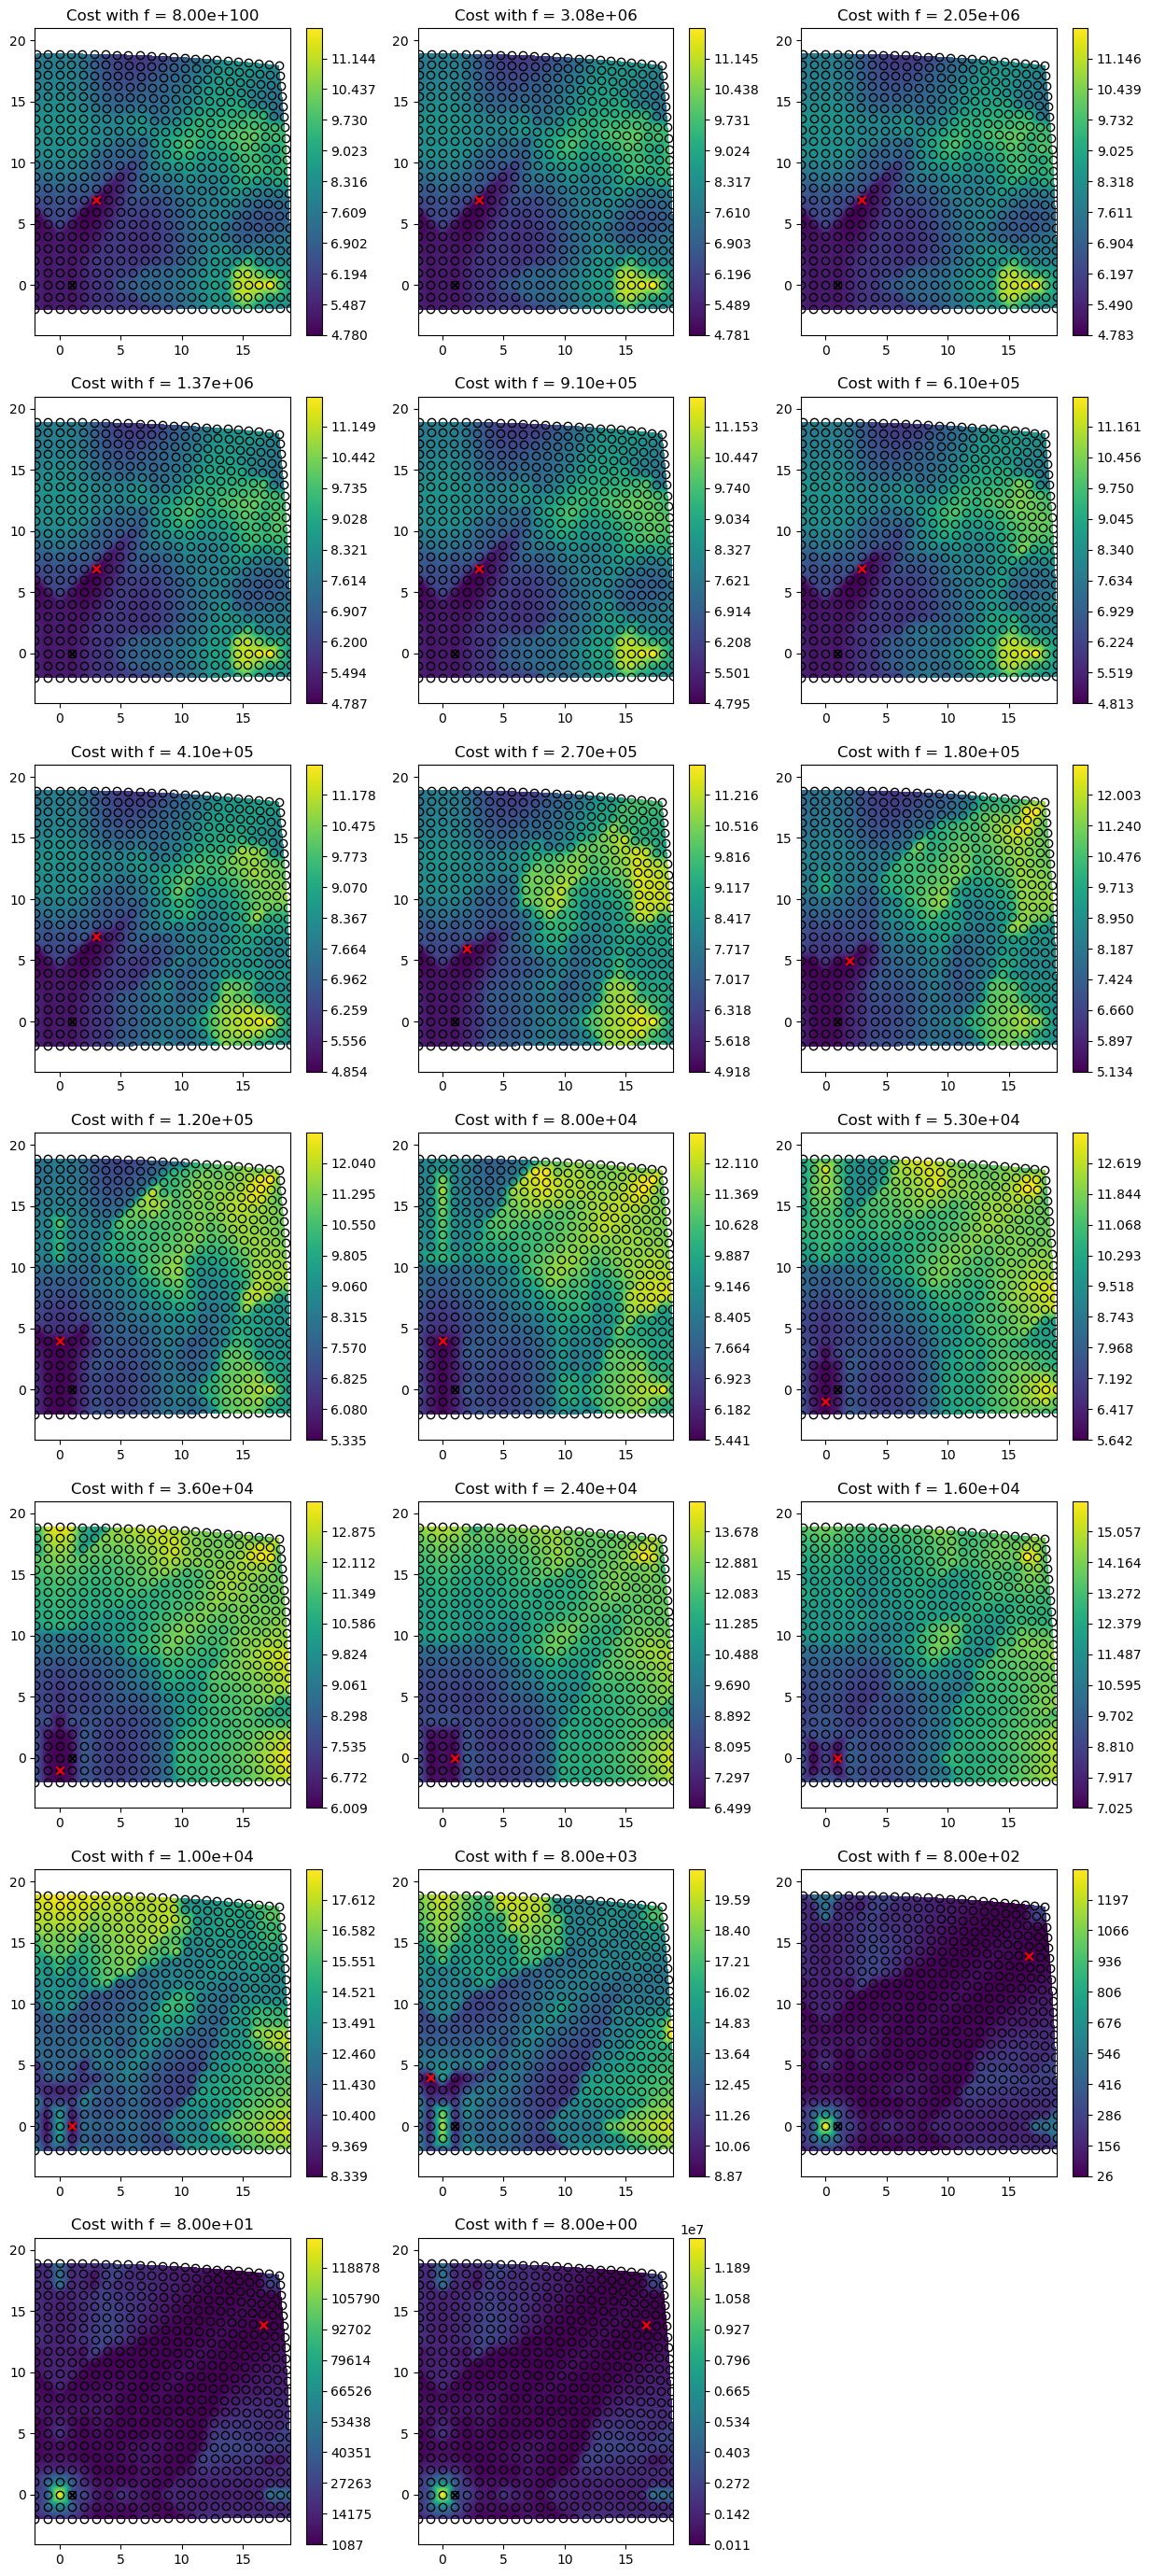

In [13]:
fig = plt.figure(figsize=(15,5*(len(all_keys)//3+1)))

sort_a_par_w = sorted(range(len(a_par_keys)), key=lambda i: float(a_par_keys[i].removeprefix("Reconstructed_weight_")))
no_a_par_index = sort_a_par_w[0]
print(sort_a_par_w)

for j, i in enumerate(sort_a_par_w):
    ax = fig.add_subplot(len(all_keys)//3+1,3,j+1)
    
    
    ax.plot(all_B[i][:,0]*180/np.pi, all_B[i][:,1]*180/np.pi, 'o', color="black", mfc='none')
    sc = ax.tricontourf(all_B[i][:,0]*180/np.pi, all_B[i][:,1]*180/np.pi, all_errors[i], levels=np.linspace(np.min(all_errors[i]), np.max(all_errors[i]), 500))
    
    n = np.argmin(all_errors[i])
    ax.scatter(all_B[i][n,0]*180/np.pi, all_B[i][n,1]*180/np.pi, c="red", marker="x", zorder=1000)

    ax.set_title(f"Cost with f = {float(a_par_keys[i].removeprefix("Reconstructed_weight_"))**(-0.5):.2e}")
    
    n = np.argmin(np.linalg.norm(all_B[i][:,:2] - target_B, axis=1))
    ax.scatter(all_B[i][n,0]*180/np.pi, all_B[i][n,1]*180/np.pi, c="black", marker="x")
    
    
    ax.axis("equal")
    
    cbar = fig.colorbar(sc)

# Focus on one solution

In [16]:
a_par_index = no_a_par_index

n = np.argmin(np.linalg.norm(all_B[a_par_index][:,:2] - target_B, axis=1))
key = all_keys[a_par_index][n]
B = all_B[a_par_index][n]

print(f"error: {np.min(all_errors[a_par_index])} @ {n}")

with h5py.File(couplings_file, "r") as f:
    all_couplings = f[f"{key}/SEDOR_couplings"][:]
    a_parallel = f[f"{key}/A_par_couplings"][:]
    nb_par = f[f"{key}/NB_couplings"][:]

sites = np.array([index_to_coord(all_final_sites[a_par_index][n][i], max_distance, 4) for i in range(len(all_final_sites[a_par_index][0]))], dtype = np.int64)

selected_site = np.array([coord_to_index(i, max_distance, site_nb) for i in sites])

sites, key, a_par_keys[a_par_index], all_final_sites[a_par_index][n]

error: 4.7801243497173935 @ 49


(array([[ 0,  0,  0,  3],
        [ 1,  0,  1,  0],
        [-1,  1,  0,  1],
        [-1,  0,  1,  0],
        [-1,  0,  0,  1],
        [ 2,  0,  0,  3],
        [ 1, -1,  0,  0],
        [ 0,  1,  1,  1],
        [ 0,  0,  1,  0]]),
 'B_sweep_0_1',
 'Reconstructed_weight_1.5625e-202',
 array([1459, 1784, 1169, 1136, 1133, 2107, 1744, 1497, 1460], dtype=uint64))

### Abundancy

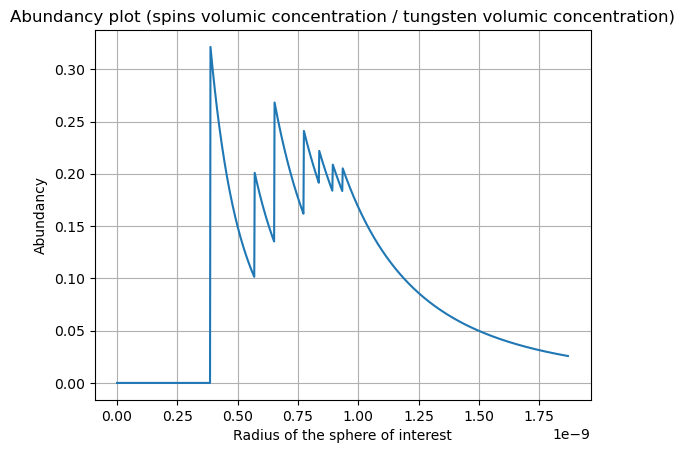

In [17]:
positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]
radius = np.max(np.linalg.norm(positions-erbium_position, axis = 1))

full_sites = np.array([index_to_coord(i, max_distance, 4) for i in range(4*max_distance**3)])
full_positions = lattice_x[None,:]*full_sites[:,0][:,None] + lattice_y[None,:] * full_sites[:,1][:,None] + lattice_z[None,:] * full_sites[:,2][:,None] + lattice_s[full_sites[:,3]]

full_concentration = 4/(a*c*a)


r = np.linspace(0.1e-30, 2*radius, 1000)

nn = np.array([np.sum(np.linalg.norm(positions-erbium_position, axis = 1) < ra) for ra in r])

fig, ax = plt.subplots(1)

ax.set_title("Abundancy plot (spins volumic concentration / tungsten volumic concentration)")

ax.set_xlabel("Radius of the sphere of interest")
ax.set_ylabel("Abundancy")
ax.grid()

ax.plot(r, nn/(4/3*np.pi*r**3)/4*a*a*c)

### Reconstruction visualisations

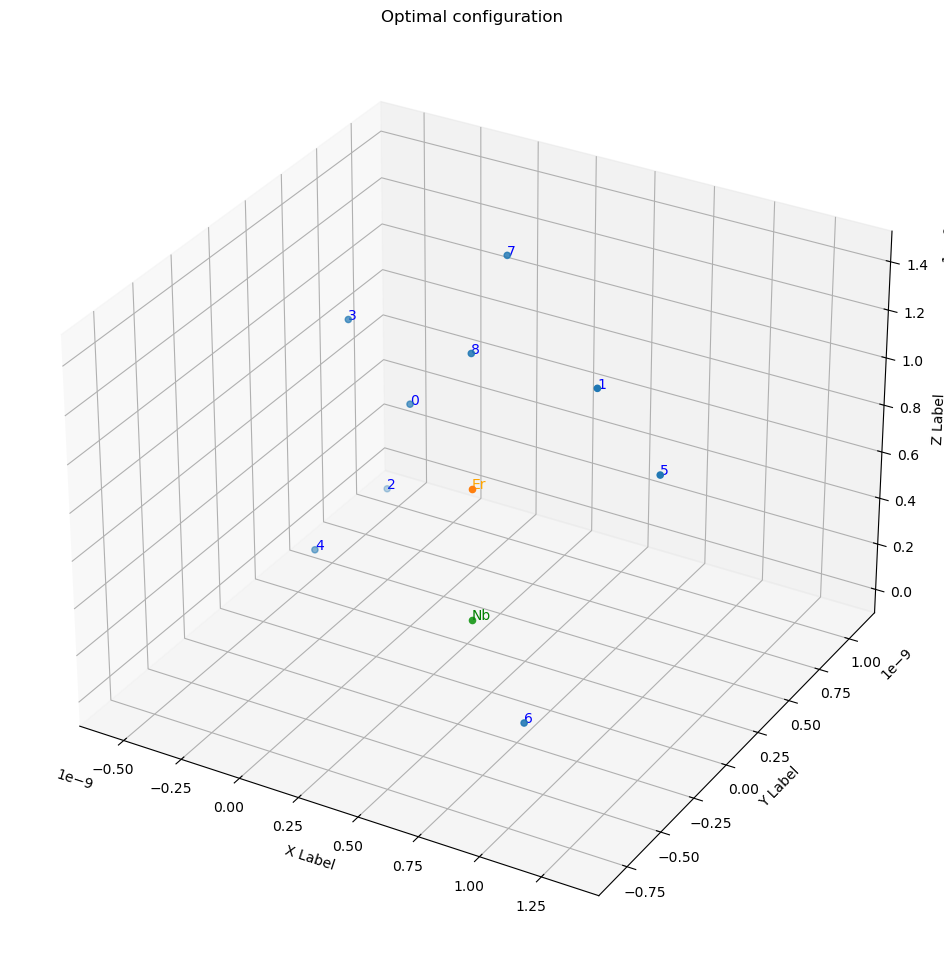

In [18]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.set_title(f"Optimal configuration")
sites = np.array([index_to_coord(i, max_distance, 4) for i in selected_site], dtype = np.int64)
positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]


ax.scatter(positions[:,0], positions[:,1], positions[:,2])

ax.scatter(0.5*a, 0.5*a, 0.5*c)
ax.scatter(0.5*a, 0.5*a, 0)
ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
ax.text(0.5*a, 0.5*a, 0, "Nb", color="green")


for i in range(len(positions)):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')
pass


### Comparing reconstructed data to real data

In [19]:
reconstructed_couplings = np.array([[all_couplings[i, j] for j in selected_site] for i in selected_site])

In [20]:
def plot_comparison_table(meas, sim, cmap='summer', title='Measurement vs Simulation Comparison'):
    """
    Plots an NxN comparison table with a 2:1 figure aspect ratio.
    Cells with NaN in either measurement or simulation are left uncolored.

    Is this a better implem or the same ? => https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    """
    N = meas.shape[0]
    M = meas.shape[1]
    # Compute absolute discrepancies, ignoring NaNs for normalization
    diff = np.abs(meas - sim)
    norm = plt.Normalize(vmin=np.nanmin(diff), vmax=np.nanmax(diff))
    cmap = plt.get_cmap(cmap)
    
    # Create a wider figure: width = 2 * height
    fig, ax = plt.subplots(figsize=(2 * N*0.75+0.8, M*0.75+0.8))
    ax.set_xlim(0, N)
    ax.set_ylim(0, M)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(N+1))
    ax.set_yticks(np.arange(M+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.grid(False)
    
    for i in range(N):
        for j in range(min(i+1, M)):
            d = diff[i, j]
            # Skip coloring if NaN
            if np.isnan(d):
                cell_color = 'none'
            else:
                cell_color = cmap(norm(d))
            # Draw cell
            rect = plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black')
            ax.add_patch(rect)
            # Diagonal line
            ax.plot([i+1, i], [j, j+1], color='black', linewidth=1)
            # Text values (show 'nan' if NaN)
            meas_val = meas[i, j]
            sim_val = sim[i, j]
            txt_meas = f'{meas_val:.2f}' if not np.isnan(meas_val) else 'nan'
            txt_sim  = f'{sim_val:.2f}'  if not np.isnan(sim_val)  else 'nan'
            ax.text(i + 0.05, j + 0.15, txt_meas, va='top', ha='left', fontsize=10)
            ax.text(i + 0.95, j + 0.85, txt_sim,  va='bottom', ha='right', fontsize=10)
    
    # Colorbar (exclude NaNs)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(diff[~np.isnan(diff)])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Absolute discrepancy')
    
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


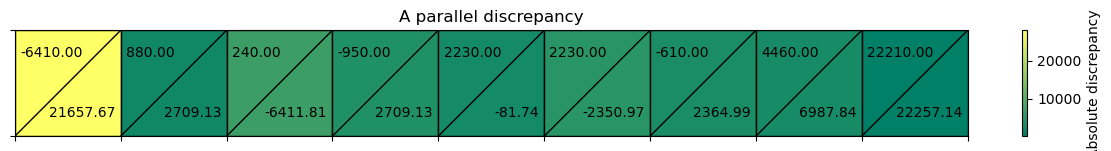

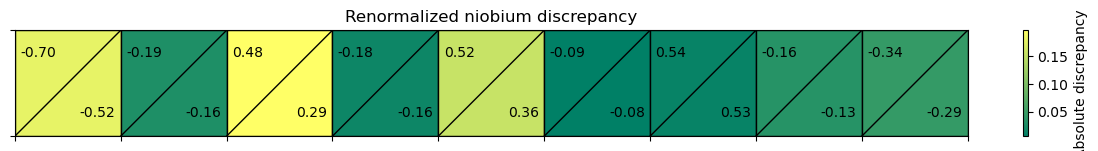

In [21]:

plot_comparison_table(a_par_data[:,None],  np.array([a_parallel[s] for s in selected_site])[:,None], title="A parallel discrepancy")
plot_comparison_table(nb_par_data[:,None]*gamma_ratio, np.array([nb_par[s] for s in selected_site])[:,None]*gamma_ratio, title="Renormalized niobium discrepancy")

In [22]:
for i in range(9):
    for j in range(9):
        if not np.isnan(renormalized_data[i,j]):
            print(f"  [{i}, {j}],")

  [0, 1],
  [0, 2],
  [0, 3],
  [0, 4],
  [0, 5],
  [0, 6],
  [0, 7],
  [0, 8],
  [1, 2],
  [1, 3],
  [1, 4],
  [1, 5],
  [1, 8],
  [2, 3],
  [2, 5],
  [2, 6],
  [2, 8],
  [3, 5],
  [3, 7],
  [3, 8],


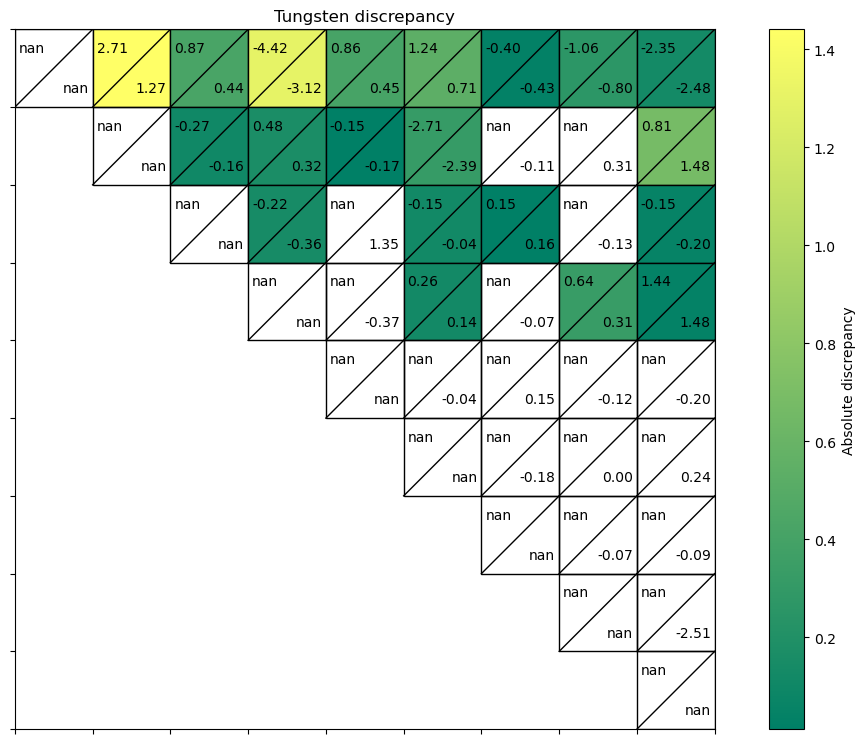

In [23]:
plot_comparison_table(renormalized_data.T, reconstructed_couplings, title="Tungsten discrepancy")

# Solution number estimation

In [25]:
B_key = all_keys[a_par_index][n]
print(B_key)
with (
    h5py.File(file, "r") as g
):
    a_par_key = a_par_keys[a_par_index]
        
    err = g[f"{a_par_key}/Reconstructed_from_{B_key}/errors"][:]
    all_sites = g[f"{a_par_key}/Reconstructed_from_{B_key}/sites"][:]
    permut_inv = invert_permutation(g[f"{a_par_key}/Reconstructed_from_{B_key}/permutation"][:])

B_sweep_0_1


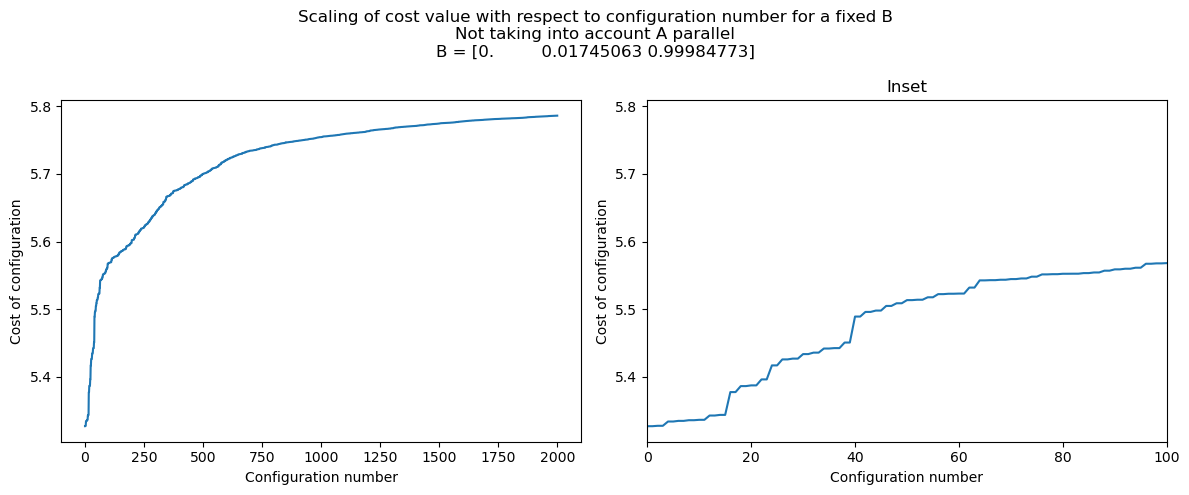

In [26]:
fig = plt.figure(figsize=(12,5))

fig.suptitle(f"Scaling of cost value with respect to configuration number for a fixed B\nNot taking into account A parallel\nB = {B}")

ax = fig.add_subplot(1,2,1)

ax.plot(range(len(err)), err)

ax.set_xlabel("Configuration number")

ax.set_ylabel("Cost of configuration")


ax = fig.add_subplot(1,2,2, sharey=ax)

ax.set_title("Inset")

ax.plot(range(len(err)), err)
ax.set_xlim(0,100)

ax.set_xlabel("Configuration number")

ax.set_ylabel("Cost of configuration")
plt.tight_layout()

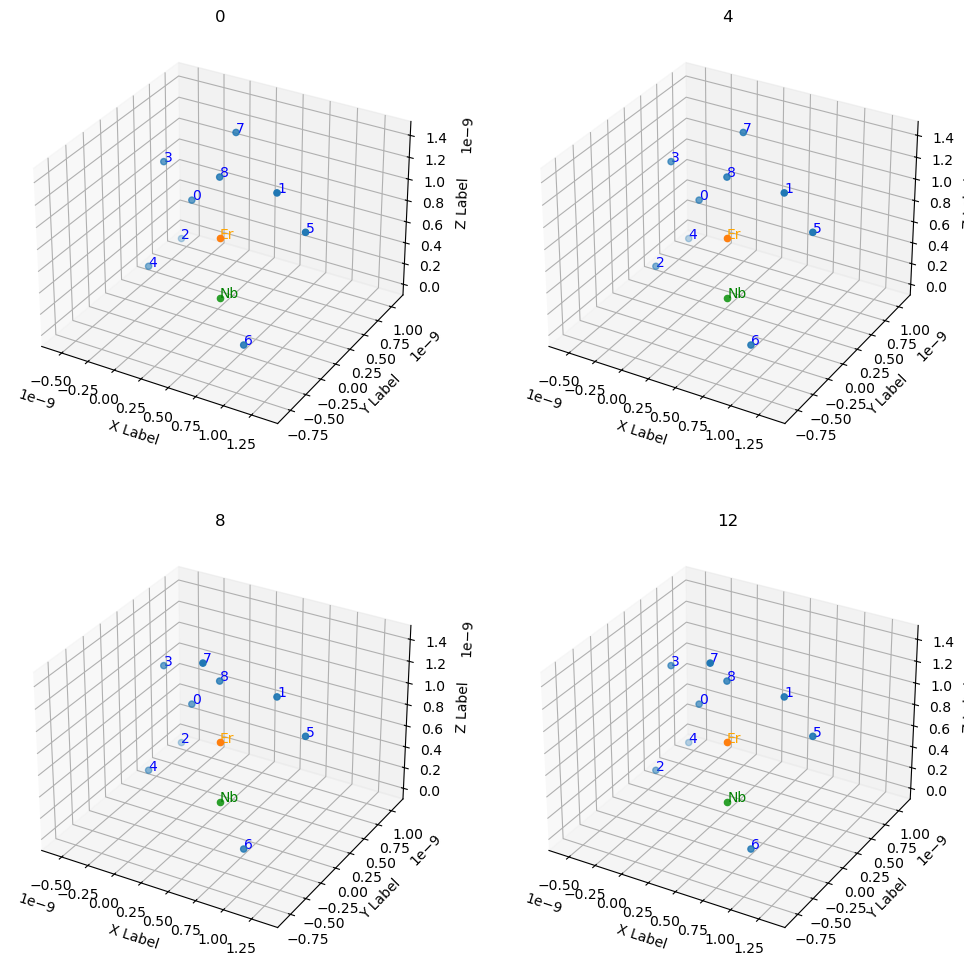

In [27]:
fig = plt.figure(figsize=(12,12))
for j, m in enumerate(range(0,16,4)):
    ax = fig.add_subplot(2,2,j+1, projection="3d")
    ax.set_title(f"{m}")
    sites = np.array([index_to_coord(i, max_distance, 4) for i in all_sites[m][permut_inv]], dtype = np.int64)
    positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]

    ax.scatter(positions[:,0], positions[:,1], positions[:,2])
    
    ax.scatter(0.5*a, 0.5*a, 0.5*c)
    ax.scatter(0.5*a, 0.5*a, 0)
    ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
    ax.text(0.5*a, 0.5*a, 0, "Nb", color="green")
    
    
    for i in range(len(positions)):
        ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.axis('equal')


# DEPRECATED CODE

In [28]:
config_map = np.unique(all_final_sites, axis=0)

print(f"Number of regions = {len(config_map)}")

region = np.empty(len(all_final_sites), dtype = np.uint64)

for i, conf in enumerate(config_map):
    mask = np.all(all_final_sites == conf, axis=1)
    region[mask] = i
    

fig, ax = plt.subplots()

ax.set_title("Optimal solution")

sc = ax.scatter(all_B[:,0]*180/np.pi, all_B[:,1]*180/np.pi, c=region, cmap="hsv") #levels = np.arange(len(config_map)+1) - 0.5)

n = np.argmin(all_errors)
ax.scatter(all_B[n,0]*180/np.pi, all_B[n,1]*180/np.pi, c="red", marker="x")


n = np.argmin(np.linalg.norm(all_B[:,:2]- target_B, axis=1))
ax.scatter(all_B[n,0]*180/np.pi, all_B[n,1]*180/np.pi, c="black", marker="x")
ax.axis("equal")
cbar = fig.colorbar(sc)
cbar.set_label("Region")

Number of regions = 20


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed